
# Music Synchronization with Dynamic Time Warping

In this short tutorial, we demonstrate the use of dynamic time warping (DTW) for music synchronization
which is implemented in `librosa`.

We assume that you are familiar with the algorithm and focus on the application. Further information about
the algorithm can be found in the literature, e. g. [1]_.

Our example consists of two recordings of the first bars of the famous
brass section lick in Stevie Wonder's rendition of "Sir Duke".
Due to differences in tempo, the first recording lasts for ca. 7 seconds and the second recording for ca. 5 seconds.
Our objective is now to find an alignment between these two recordings by using DTW.


In [9]:
# Code source: Stefan Balke
# License: ISC
# sphinx_gallery_thumbnail_number = 4

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio
import librosa

## Load Audio Recordings
First, let's load a first version of our audio recordings.



In [12]:
reference_path = 'audio/veneciana-reference.mp3'
live_path = 'audio/veneciana-live.mp3'

[Text(0.5, 1.0, 'En vivo')]

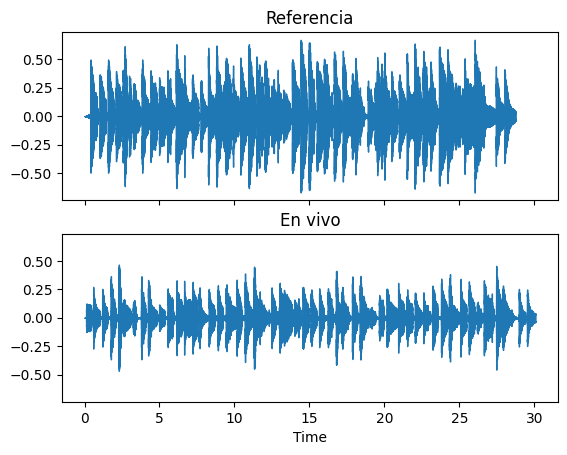

In [ ]:
reference_audio, sampling_rate = librosa.load(reference_path)
live_audio, sampling_rate = librosa.load(live_path)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.waveshow(reference_audio, sr=sampling_rate, ax=ax[0])
ax[0].set(title='Referencia')
ax[0].label_outer()

librosa.display.waveshow(live_audio, sr=sampling_rate, ax=ax[1])
ax[1].set(title='En vivo')

In [ ]:
# Listen to reference
print("Reference recording:")
Audio(data=reference_audio, rate=sampling_rate)

Reference recording:
Live recording:


In [ ]:

# Listen to reference
print("Live recording:")
Audio(data=live_audio, rate=sampling_rate)

## Extract Chroma Features



In [ ]:
def extract_chroma(audio, sampling_rate, hop_length):
    # Extract chroma features from reference recording
    chroma_reference = librosa.feature.chroma_cqt(y=audio, sr=sampling_rate, 
                                                hop_length=hop_length,
                                                n_chroma=12,
                                                bins_per_octave=36
                                                )
    return chroma_reference

def to_zeros_chroma(chroma):
    # Crear una matriz de ceros del mismo tamaño que chroma
    normalized = np.zeros_like(chroma)
    
    # Para cada columna (instante temporal)
    for i in range(chroma.shape[1]):
        # Obtener el índice del pitch class con mayor valor
        max_index = np.argmax(chroma[:, i])
        # Asignar el valor original en esa posición
        normalized[max_index, i] = chroma[max_index, i]
    
    return normalized

def normalize_chroma(chroma, alpha=0.1):
    # Copiamos el contenido original para aplicar la atenuación
    normalized = chroma.copy()
    
    # Para cada columna (instante temporal)
    for i in range(chroma.shape[1]):
        # Índice del pitch class con mayor valor
        # Atenuar todas las clases
        normalized[:, i] *= alpha
        
        max_index = np.argmax(chroma[:, i])
        
        
        # Restaurar el valor original de la clase predominante
        normalized[max_index, i] = chroma[max_index, i]
    
    return normalized

def normalize_chroma_logarithmic(chroma, alpha=0.1):
    # Copiamos el contenido original para aplicar la atenuación
    normalized = chroma.copy()
    
    # Para cada columna (instante temporal)
    for i in range(chroma.shape[1]):
        # Índice del pitch class con mayor valor
        # Atenuar todas las clases
        normalized[:, i] *= alpha
        
        max_index = np.argmax(chroma[:, i])
        
        # Restaurar el valor original de la clase predominante
        normalized[max_index, i] = np.log(chroma[max_index, i])
    
    return normalized


def visualize_chroma(chroma, hop_length, sr, title='Chroma features'):
    # Visualize reference chroma
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma',
                            hop_length=hop_length, sr=sampling_rate)
    plt.colorbar(label='Normalized amplitude')
    plt.title(title)
    plt.tight_layout()

In [18]:
from scipy.ndimage import median_filter

def smooth_chroma_median(chroma, size=3):
    # Aplica un filtro de mediana a cada fila (pitch class)
    smoothed = median_filter(chroma, size=(1, size))
    return smoothed

def remove_short_activations(chroma, min_duration_frames=2):
    cleaned = np.zeros_like(chroma)
    for pitch_class in range(chroma.shape[0]):
        active = chroma[pitch_class, :] > 0
        start = None
        for i in range(len(active)):
            if active[i] and start is None:
                start = i
            elif not active[i] and start is not None:
                if i - start >= min_duration_frames:
                    cleaned[pitch_class, start:i] = chroma[pitch_class, start:i]
                start = None
        # Por si acaba activo
        if start is not None and len(active) - start >= min_duration_frames:
            cleaned[pitch_class, start:] = chroma[pitch_class, start:]
    return cleaned


In [19]:
# Escala logarítmica para cromograma para potenciar los que tengan más energía
def log_scale_chroma(chroma):
    # Aplicar la escala logarítmica
    chroma_log = np.log1p(chroma)
    # Normalizar
    chroma_log /= np.max(chroma_log)
    return chroma_log


In [20]:
def normalize_chroma_log(chroma, alpha=1e-3):
    # Añadimos un pequeño valor para evitar log(0)
    chroma_log = np.log1p(chroma / alpha)  # log(1 + chroma/alpha)
    chroma_log /= np.max(chroma_log)  # Normaliza entre 0 y 1
    return chroma_log


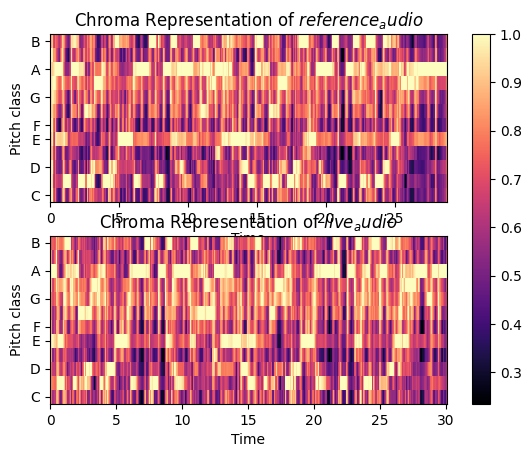

In [ ]:
hop_length = 1024
min_frames = 5
alpha = 1

reference_audio_chroma = extract_chroma(reference_audio, sampling_rate, hop_length)
# reference_audio_chroma = normalize_chroma(reference_audio_chroma, alpha)
# reference_audio_chroma = remove_short_activations(reference_audio_chroma, min_duration_frames=3)
# reference_audio_chroma = smooth_chroma_median(reference_audio_chroma, size=3)
# reference_audio_chroma = normalize_chroma_log(reference_audio_chroma, alpha)
reference_audio_chroma = normalize_chroma_log(reference_audio_chroma)

live_audio_chroma = extract_chroma(live_audio, sampling_rate, hop_length)
# live_audio_chroma = normalize_chroma(live_audio_chroma, alpha)
# live_audio_chroma = remove_short_activations(live_audio_chroma, min_duration_frames=min_frames)
# live_audio_chroma = smooth_chroma_median(live_audio_chroma, size=3)
# live_audio_chroma = normalize_chroma_log(live_audio_chroma, alpha)
live_audio_chroma = normalize_chroma_log(live_audio_chroma)

fig, ax = plt.subplots(nrows=2, sharey=True)
img = librosa.display.specshow(reference_audio_chroma, x_axis='time',
                               y_axis='chroma',
                               hop_length=hop_length, ax=ax[0])
ax[0].set(title='Chroma Representation of $reference_audio$')
librosa.display.specshow(live_audio_chroma, x_axis='time',
                         y_axis='chroma',
                         hop_length=hop_length, ax=ax[1])
ax[1].set(title='Chroma Representation of $live_audio$')
fig.colorbar(img, ax=ax)



## Align Chroma Sequences



6.1932243725433676


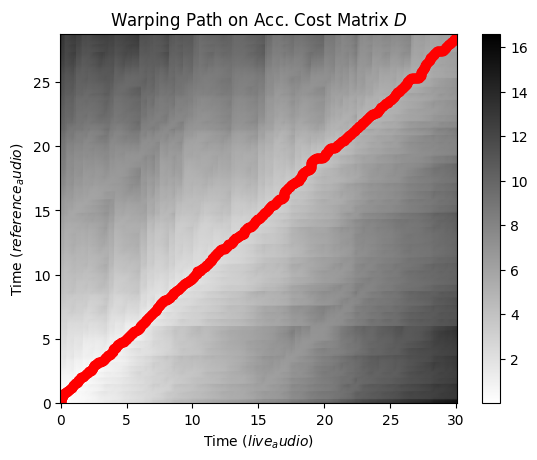

In [ ]:
D, wp = librosa.sequence.dtw(X=reference_audio_chroma, Y=live_audio_chroma, metric='cosine')
wp_s = librosa.frames_to_time(wp, sr=sampling_rate, hop_length=hop_length)
print(D[-1, -1])

fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='time', sr=sampling_rate,
                               cmap='gray_r', hop_length=hop_length, ax=ax)
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
ax.set(title='Warping Path on Acc. Cost Matrix $D$',
       xlabel='Time $(live_audio)$', ylabel='Time $(reference_audio)$')
fig.colorbar(img, ax=ax)

## Alternative Visualization in the Time Domain

We can also visualize the warping path directly on our time domain signals.
Red lines connect corresponding time positions in the input signals.
(Thanks to F. Zalkow for the nice visualization.)



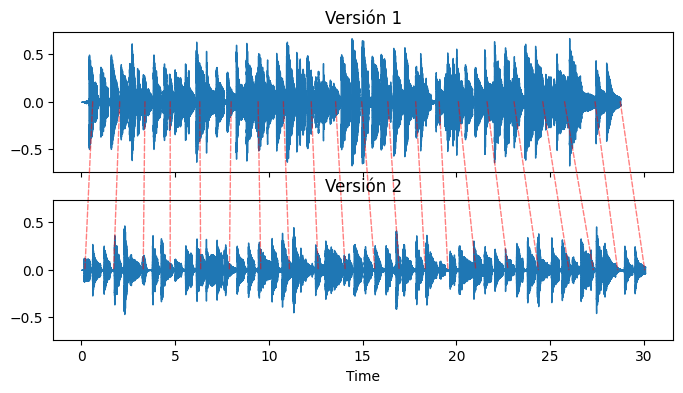

In [23]:
from matplotlib.patches import ConnectionPatch

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,4))

# Plot live_audio
librosa.display.waveshow(live_audio, sr=sampling_rate, ax=ax2)
ax2.set(title='Versión 2')

# Plot reference_audio
librosa.display.waveshow(reference_audio, sr=sampling_rate, ax=ax1)
ax1.set(title='Versión 1')
ax1.label_outer()


n_arrows = 20
for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
    # Create a connection patch between the aligned time points
    # in each subplot
    con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='--',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)

C:\Users\sarag\AppData\Local\Temp\ipykernel_24348\2426655129.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


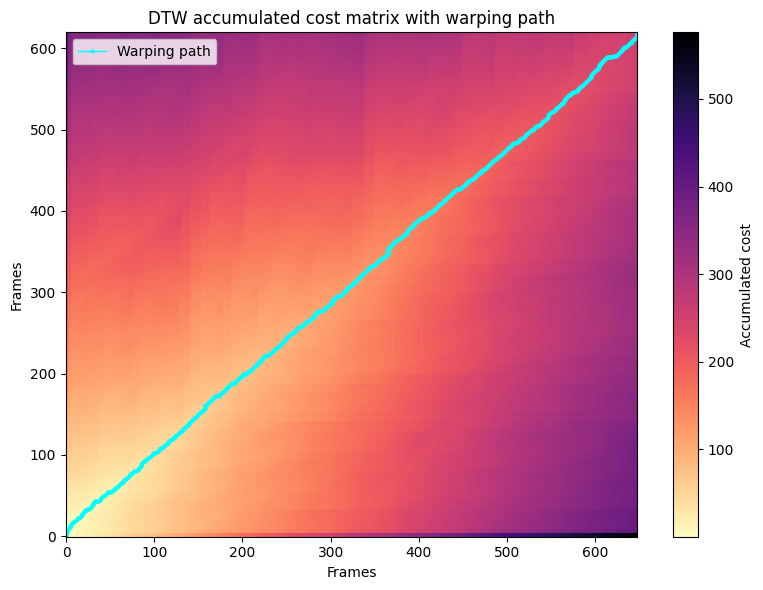

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Supón que tienes D y wp ya calculados
D, wp = librosa.sequence.dtw(X=reference_audio_chroma, Y=live_audio_chroma, backtrack=True)

# Crear la figura
fig, ax = plt.subplots(figsize=(8, 6))

# Mostrar la matriz D
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames', cmap='magma_r', ax=ax)
fig.colorbar(img, ax=ax, label='Accumulated cost')

# Dibujar el camino de alineación
wp_x, wp_y = zip(*wp)
ax.plot(wp_y, wp_x, marker='o', color='cyan', markersize=2, linewidth=1, label='Warping path')

ax.set_title('DTW accumulated cost matrix with warping path')
ax.legend()
plt.tight_layout()
plt.show()


## Corrección estática de la velocidad

In [25]:
def estimate_stretch_factor(wp_s):
    """
    Calcula el factor de velocidad necesario para que el audio de referencia
    se sincronice temporalmente con el audio en vivo.
    
    Parámetro:
        wp_s: np.ndarray de shape (n, 2)
            Ruta DTW invertida (ordenada en el tiempo).
            
    Retorna:
        stretch_factor: float
            Factor de velocidad a aplicar al audio de referencia.
            >1 significa más rápido, <1 más lento.
    """
    ref_start, live_start = wp_s[0]
    ref_end, live_end = wp_s[-1]
    
    ref_frames = ref_end - ref_start + 1
    live_frames = live_end - live_start + 1
    
    return ref_frames / live_frames  # factor de velocidad

# Aplicar DTW a cada punto de sincronización
def apply_dtw_to_sync(reference_audio, live_audio, wp_s, sampling_rate, hop_length):
    """
    Aplica DTW a cada punto de sincronización y devuelve el audio sincronizado.
    
    Parámetros:
        reference_audio: np.ndarray
            Audio de referencia.
        live_audio: np.ndarray
            Audio en vivo.
        wp_s: np.ndarray
            Ruta DTW invertida (ordenada en el tiempo).
        sampling_rate: int
            Frecuencia de muestreo.
        hop_length: int
            Longitud del salto.
            
    Retorna:
        x_1_sync: np.ndarray
            Audio de referencia sincronizado.
    """
    # Inicializar la lista para almacenar los segmentos sincronizados
    segments = []
    
    # Iterar sobre los puntos de sincronización
    for i in range(len(wp_s) - 1):
        ref_start, live_start = wp_s[i]
        ref_end, live_end = wp_s[i + 1]
        
        # Extraer el segmento del audio de referencia
        segment = reference_audio[ref_start:ref_end]
        
        # Calcular el factor de estiramiento
        stretch_factor = estimate_stretch_factor(wp_s[i:i + 2])
        
        # Aplicar el estiramiento al segmento
        segment_stretched = librosa.effects.time_stretch(segment, stretch_factor)
        
        # Añadir el segmento estirado a la lista
        segments.append(segment_stretched)
    
    # Concatenar todos los segmentos estirados
    x_1_sync = np.concatenate(segments)
    
    return x_1_sync


In [ ]:
import librosa

# reference_audio: np.ndarray
# sr: sample rate
# wp_s: ruta DTW

stretch_factor = estimate_stretch_factor(wp_s)

# Atención: time_stretch solo funciona sobre STFT o sobre el audio si lo conviertes a mono
reference_audio_mono = librosa.to_mono(reference_audio)
reference_audio_stretched = librosa.effects.time_stretch(reference_audio_mono, rate=stretch_factor)


In [ ]:
duration_ref = len(reference_audio) / sampling_rate
duration_stretched = len(reference_audio_stretched) / sampling_rate
print(f"Original: {duration_ref:.2f}s, Estirado: {duration_stretched:.2f}s")


Original: 16.47s, Estirado: 22.16s


In [ ]:
import soundfile as sf
sf.write("reference_synchronized.mp3", reference_audio_stretched, sampling_rate)


[Text(0.5, 1.0, 'Versión 1 Estirada')]

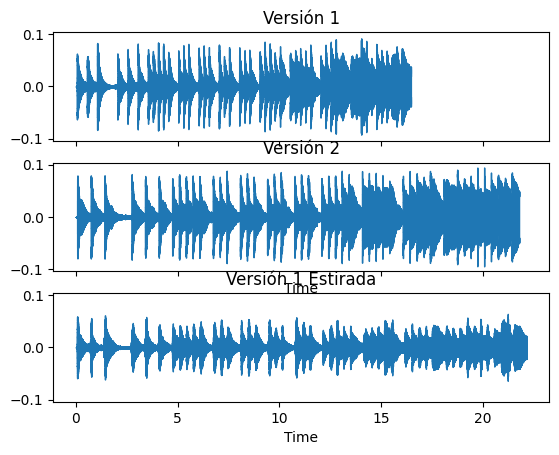

In [ ]:
reference_audio, sampling_rate = librosa.load(reference_path)
live_audio, sampling_rate = librosa.load(live_path)
reference_audio_stretched, sampling_rate = librosa.load("reference_synchronized.mp3")

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
librosa.display.waveshow(reference_audio, sr=sampling_rate, ax=ax[0])
ax[0].set(title='Versión 1')
ax[0].label_outer()

librosa.display.waveshow(live_audio, sr=sampling_rate, ax=ax[1])
ax[1].set(title='Versión 2')

librosa.display.waveshow(reference_audio_stretched, sr=sampling_rate, ax=ax[2])
ax[2].set(title='Versión 1 Estirada')

121.05365694283834


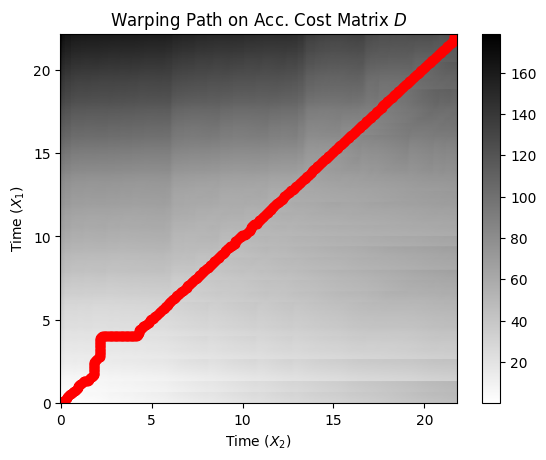

In [ ]:
streched_chroma = extract_chroma(reference_audio_stretched, sampling_rate, hop_length)

D, wp = librosa.sequence.dtw(X=streched_chroma, Y=live_audio_chroma, metric='cosine')
wp_s = librosa.frames_to_time(wp, sr=sampling_rate, hop_length=hop_length)
print(D[-1, -1])

fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='time', sr=sampling_rate,
                               cmap='gray_r', hop_length=hop_length, ax=ax)
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
ax.set(title='Warping Path on Acc. Cost Matrix $D$',
       xlabel='Time $(live_audio)$', ylabel='Time $(reference_audio)$')
fig.colorbar(img, ax=ax)

## Corrección diámica de la velocidad

Perfecto, ahora quieres **aplicar una corrección dinámica de tiempo** al audio de referencia (`live_path`), para que se **ajuste localmente a la curva de sincronización DTW** (almacenada en `wp` o `wp_s`), **sin usar un único factor de estiramiento global**.

🧠 Objetivo
Alinear dos audios con DTW, y luego modificar uno (digamos, audio_ref) para que sus eventos ocurran a los mismos tiempos que en audio_live, aplicando estiramientos o compresiones dinámicos (no globales) según wp.

✅ Solución: usar librosa.effects.time_stretch localmente por fragmentos
La clave es procesar el audio por tramos, según wp, y para cada tramo:
* extraer el fragmento original,
* calcular la duración deseada,
* aplicar librosa.effects.time_stretch para estirarlo o acortarlo.


In [233]:
import librosa
import numpy as np

def time_warp_audio(audio_ref, sr, wp, hop_length=512):
    warped_audio = []

    wp = np.array(wp)[::-1]  # Asegúrate de que está en orden creciente

    for i in range(1, len(wp)):
        t_live_start = wp[i - 1, 0]
        t_ref_start  = wp[i - 1, 1]
        t_live_end   = wp[i, 0]
        t_ref_end    = wp[i, 1]

        ref_start = t_ref_start * hop_length
        ref_end   = t_ref_end * hop_length

        live_start = t_live_start * hop_length
        live_end   = t_live_end * hop_length

        # Evita segmentos vacíos o fuera de rango
        if ref_end <= ref_start or ref_end > len(audio_ref):
            continue

        # Segmentos originales
        segment = audio_ref[ref_start:ref_end]
        ref_dur = len(segment) / sr
        live_dur = (live_end - live_start) / sr

        # Si la duración de destino es muy pequeña, saltar
        if live_dur <= 0 or ref_dur <= 0:
            continue

        # Calcula el factor de estiramiento/comprensión
        stretch_factor = ref_dur / live_dur

        # Aplica estiramiento dinámico
        segment_stretched = librosa.effects.time_stretch(segment, rate=stretch_factor)

        warped_audio.append(segment_stretched)

    if len(warped_audio) == 0:
        raise ValueError("No se generó ningún segmento válido.")

    return np.concatenate(warped_audio)


In [ ]:
reference_path = 'audio/Acordai-80.mp3'
live_path = 'audio/Acordai-90.mp3'
reference_audio, sampling_rate = librosa.load(reference_path)
live_audio, sampling_rate = librosa.load(live_path)

reference_audio_chroma = extract_chroma(reference_audio, sampling_rate, hop_length)
live_audio_chroma = extract_chroma(live_audio, sampling_rate, hop_length)

D, wp = librosa.sequence.dtw(X=live_audio_chroma, Y=reference_audio_chroma, metric='cosine')
print(D[-1, -1])

4.525633241533987


In [259]:
ruta_1 = "audio_1_alineado.mp3"
ruta_2 = "audio_2_alineado.mp3"

In [ ]:
D, wp = librosa.sequence.dtw(X=live_audio_chroma, Y=reference_audio_chroma, metric='cosine')
warped_audio_1 = time_warp_audio(reference_audio, sampling_rate, wp, hop_length)
sf.write('x2_x1'+ruta_1, warped_audio_1, sampling_rate)
warped_audio_2 = time_warp_audio(live_audio, sampling_rate, wp, hop_length)
sf.write('x2_x1'+ruta_2, warped_audio_2, sampling_rate)


In [ ]:
D, wp = librosa.sequence.dtw(X=reference_audio_chroma, Y=live_audio_chroma, metric='cosine')
warped_audio_1 = time_warp_audio(reference_audio, sampling_rate, wp, hop_length)
sf.write('x1_x2'+ruta_1, warped_audio_1, sampling_rate)
warped_audio_2 = time_warp_audio(live_audio, sampling_rate, wp, hop_length)
sf.write('x1_x2'+ruta_2, warped_audio_2, sampling_rate)

In [252]:
from scipy.interpolate import interp1d
import numpy as np

def warp_audio_dtw_full(audio_ref, wp, sr, hop_length=512):
    """
    Warp audio_ref to match the timing of wp[:,0] (target times)
    based on alignment wp from DTW.
    """
    wp = np.array(wp)
    wp = wp[::-1]  # Orden ascendente

    # Convert frame indices to time in seconds
    time_ref = wp[:, 1] * hop_length / sr
    time_target = wp[:, 0] * hop_length / sr

    # Crear función de remapeo: tiempo deseado -> tiempo original
    f = interp1d(time_ref, time_target, kind='linear', fill_value='extrapolate')

    # Vector de tiempos del audio original
    t_original = np.arange(len(audio_ref)) / sr

    # Obtener nuevo tiempo destino para cada muestra
    t_warped = f(t_original)

    # Evita que el tiempo destino se salga del rango
    t_warped = np.clip(t_warped, 0, t_warped[-1])

    # Crear señal re-muestreada (a partir del tiempo "estirado")
    warped_audio = np.interp(t_warped, t_original, audio_ref)

    return warped_audio


In [ ]:
warped_audio = warp_audio_dtw_full(reference_audio, wp, sampling_rate, hop_length=512)
sf.write(ruta_1, warped_audio, sampling_rate)


c:\Users\sarag\Desktop\TFG\MetronIA\.conda\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\sarag\Desktop\TFG\MetronIA\.conda\Lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


# The Beat Spectrum

In [ ]:
import librosa
import numpy as np

# Paso 1: Calcular el espectrograma o MFCC (representación del contenido)

def extract_features(audio, sr, hop_length=512, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = librosa.util.normalize(mfcc, axis=1)
    return mfcc.T  # frames x features

In [27]:
# Paso 2: Calcular matriz de autosemejanza
from scipy.spatial.distance import cdist

def compute_self_similarity_matrix(features):
    # Usa distancia coseno para medir la semejanza
    D = cdist(features, features, metric='cosine')
    S = 1 - D  # Convertimos distancia en similitud (1: iguales, 0: ortogonales)
    return S

In [28]:
# Paso 3: Calcular el beat spectrum
def compute_beat_spectrum(S):
    n = S.shape[0]
    beat_spectrum = np.array([
        np.mean(np.diag(S, k=lag)) for lag in range(1, n)
    ])
    return beat_spectrum

In [29]:
# Paso 4: Visualizar
import matplotlib.pyplot as plt

def plot_beat_spectrum(beat_spectrum, sr, hop_length):
    times = np.arange(1, len(beat_spectrum) + 1) * hop_length / sr
    plt.figure(figsize=(10, 4))
    plt.plot(times, beat_spectrum)
    plt.xlabel("Time Lag (s)")
    plt.ylabel("Similarity")
    plt.title("Beat Spectrum")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

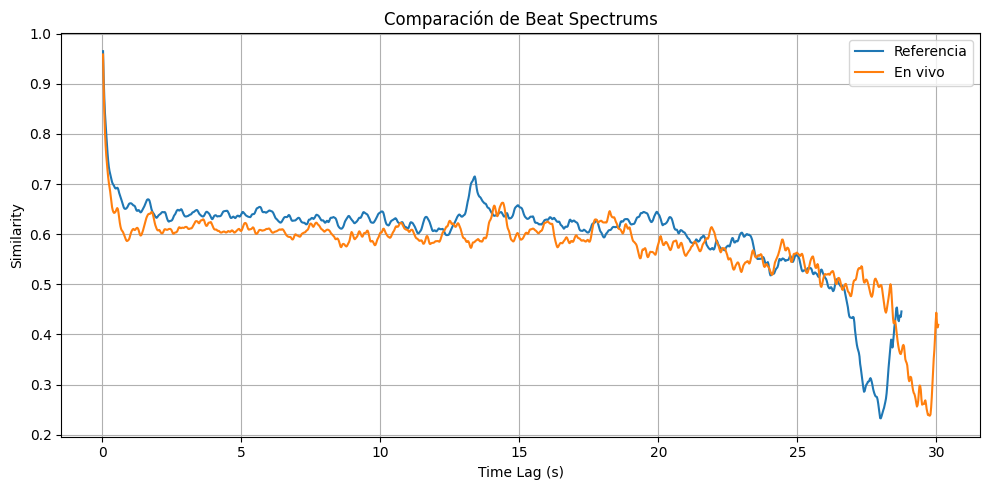

In [30]:
# Parámetros
hop_length = 512

# Referencia
ref_feat = extract_features(reference_audio, sampling_rate, hop_length)
S_ref = compute_self_similarity_matrix(ref_feat)
beat_ref = compute_beat_spectrum(S_ref)

# En vivo
live_feat = extract_features(live_audio, sampling_rate, hop_length)
S_live = compute_self_similarity_matrix(live_feat)
beat_live = compute_beat_spectrum(S_live)

# Ploteo comparado
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(beat_ref)+1) * hop_length / sampling_rate, beat_ref, label="Referencia")
plt.plot(np.arange(1, len(beat_live)+1) * hop_length / sampling_rate, beat_live, label="En vivo")
plt.xlabel("Time Lag (s)")
plt.ylabel("Similarity")
plt.title("Comparación de Beat Spectrums")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Listen to reference
print("Reference recording:")
Audio(data=reference_audio, rate=sampling_rate)

Reference recording:


In [33]:
# Listen to reference
print("Live recording:")
Audio(data=live_audio, rate=sampling_rate)

Live recording:
